In [ ]:
seed=101

In [ ]:
import os
import cv2
import shutil
import requests
import numpy as np
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
from zipfile import ZipFile
from tensorflow import keras
from keras import Model
from keras import applications
from keras import regularizers
from keras import backend as K
from keras.layers import Dense,Dropout
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Download Dataset

In [ ]:
def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                # If you have chunk encoded response uncomment if
                # and set chunk_size parameter to None.
                #if chunk: 
                f.write(chunk)
    return local_filename
    
file_name=download_file("https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/zr7vgbcyr2-1.zip")
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
	# printing all the contents of the zip file
	zip.printdir()

	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

File Name                                             Modified             Size
images/                                        2020-07-09 12:36:14            0
images/imgs_part_2.zip                         2020-07-09 12:36:14   1126646990
images/imgs_part_3.zip                         2020-07-09 12:58:40   1220565093
images/imgs_part_1.zip                         2020-07-09 13:29:36   1245184680
metadata.csv                                   2020-07-09 13:53:28       316209
Extracting all the files now...
Done!


In [ ]:
file_name="images/imgs_part_1.zip"
with ZipFile(file_name, 'r') as zip:
	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')
 
file_name="images/imgs_part_2.zip"
with ZipFile(file_name, 'r') as zip:
	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

file_name="images/imgs_part_3.zip"
with ZipFile(file_name, 'r') as zip:
	# extracting all the files
	print('Extracting all the files now...')
	zip.extractall()
	print('Done!')

Extracting all the files now...
Done!
Extracting all the files now...
Done!
Extracting all the files now...
Done!


#Move all images to one folder

In [ ]:
os.mkdir("/content/all_images")
source_dir="/content/imgs_part_1"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="/content/imgs_part_2"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

source_dir="/content/imgs_part_3"
file_names = os.listdir(source_dir)
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), "/content/all_images")

# Read Meta

In [ ]:
metadata_path="/content/metadata.csv"
meta = pd.read_csv(metadata_path)
meta=meta.drop(['patient_id','lesion_id'],axis=1)

In [ ]:
meta['smoke']=meta['smoke'].map({True: 2, False: 1})
meta['smoke']=meta['smoke'].fillna(0)

meta['drink']=meta['drink'].map({True: 2, False: 1})
meta['drink']=meta['drink'].fillna(0)

meta['pesticide']=meta['pesticide'].map({True: 2, False: 1})
meta['pesticide']=meta['pesticide'].fillna(0)

meta['gender']=meta['gender'].map({'FEMALE': 2, 'MALE': 1})
meta['gender']=meta['gender'].fillna(0)

meta['skin_cancer_history']=meta['skin_cancer_history'].map({True: 2, False: 1})
meta['skin_cancer_history']=meta['skin_cancer_history'].fillna(0)

meta['cancer_history']=meta['cancer_history'].map({True: 2, False: 1})
meta['cancer_history']=meta['cancer_history'].fillna(0)

meta['has_piped_water']=meta['has_piped_water'].map({True: 2, False: 1})
meta['has_piped_water']=meta['has_piped_water'].fillna(0)

meta['has_sewage_system']=meta['has_sewage_system'].map({True: 2, False: 1})
meta['has_sewage_system']=meta['has_sewage_system'].fillna(0)

meta['biopsed']=meta['biopsed'].map({True: 2, False: 1})
meta['biopsed']=meta['biopsed'].fillna(0)

# digits
meta['fitspatrick']=meta['fitspatrick'].fillna(-1)
meta['diameter_1']=meta['diameter_1'].fillna(-1)
meta['diameter_2']=meta['diameter_2'].fillna(-1)

meta['itch']=meta['itch'].map({'True': 2, 'False': 1,'UNK':0})
meta['grew']=meta['grew'].map({'True': 2, 'False': 1,'UNK':0})
meta['hurt']=meta['hurt'].map({'True': 2, 'False': 1,'UNK':0})
meta['changed']=meta['changed'].map({'True': 2, 'False': 1,'UNK':0})
meta['bleed']=meta['bleed'].map({'True': 2, 'False': 1,'UNK':0})
meta['elevation']=meta['elevation'].map({'True': 2, 'False': 1,'UNK':0})

meta['background_father']=meta['background_father'].fillna('None')
meta['background_mother']=meta['background_mother'].fillna('None')

In [ ]:
for i in meta.columns:
  if meta[i].dtypes=='O':
    if i!="img_id":
      ls=meta[i].values.tolist()
      le = preprocessing.LabelEncoder()
      meta[i] = le.fit_transform(meta[i]) 

In [ ]:
meta

,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,cancer_history,has_piped_water,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,0.0,0.0,8,6,8,0.0,0.0,0.0,0.0,0.0,...,-1.0,3,1,1,1,1,1,1,PAT_1516_1765_530.png,1
1,1.0,1.0,10,8,55,1.0,2.0,2.0,2.0,2.0,...,5.0,1,2,2,1,2,2,2,PAT_46_881_939.png,2
2,0.0,0.0,8,6,77,0.0,0.0,0.0,0.0,0.0,...,-1.0,0,2,1,1,1,1,1,PAT_1545_1867_547.png,1
3,0.0,0.0,8,6,75,0.0,0.0,0.0,0.0,0.0,...,-1.0,0,2,1,1,1,1,1,PAT_1989_4061_934.png,1
4,1.0,2.0,10,8,79,1.0,1.0,2.0,1.0,1.0,...,5.0,1,2,2,1,1,2,2,PAT_684_1302_588.png,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,0.0,0.0,8,6,73,0.0,0.0,0.0,0.0,0.0,...,-1.0,0,2,1,1,1,1,1,PAT_1708_3156_175.png,1
2294,1.0,1.0,10,8,55,1.0,2.0,2.0,2.0,2.0,...,12.0,1,2,2,1,2,1,1,PAT_46_880_140.png,2
2295,0.0,0.0,8,6,74,0.0,0.0,0.0,0.0,0.0,...,-1.0,5,1,1,1,1,1,1,PAT_1343_1217_404.png,1
2296,1.0,1.0,10,8,58,2.0,2.0,2.0,2.0,1.0,...,4.0,1,2,1,1,1,1,2,PAT_326_690_823.png,2


#Pre-processing

In [ ]:
num_cores=1  
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
                              inter_op_parallelism_threads=num_cores, 
                              allow_soft_placement=True,
                              device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

#getting features from images
model = tf.keras.applications.MobileNetV2(input_shape=(380, 380, 3), include_top=False, weights='imagenet')

In [ ]:
for indx,i in enumerate(meta['img_id']):
    path=os.path.join("/content/all_images/",i)
    image=tf.keras.utils.load_img(path,target_size=(380,380))
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = cv2.cvtColor(input_arr,cv2.COLOR_BGR2RGB)
    input_arr=np.array([input_arr])
    input_arr=input_arr/255
    features=model.predict(input_arr)
    nx, ny,_ = features[0].shape
    d2_train_dataset = features[0].reshape(nx*ny*_)
    meta['img_id'][indx]=d2_train_dataset

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#Split Data

In [ ]:
train,test0=train_test_split(meta,test_size=0.2,random_state=seed)
valid,test=train_test_split(test0,test_size=0.5,random_state=seed)

In [ ]:
imgF=[]
for indx in train.index:
  imgF.append(train['img_id'][indx])

imgF_tst=[]
for indx in test.index:
  imgF_tst.append(test['img_id'][indx])

imgF_valid=[]
for indx in valid.index:
  imgF_valid.append(valid['img_id'][indx])

In [ ]:
target=train['diagnostic']
x=train.drop(['diagnostic','img_id','background_father'],axis=1)

target_test=test['diagnostic']
x_test=test.drop(['diagnostic','img_id','background_father'],axis=1)

target_valid=valid['diagnostic']
x_valid=valid.drop(['diagnostic','img_id','background_father'],axis=1)

In [ ]:
meta_clf = RandomForestClassifier(random_state=seed)
img_clf = LogisticRegression(random_state=seed)
img_clf.fit(imgF, target)
meta_clf.fit(x, target)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


RandomForestClassifier(random_state=101)

In [ ]:
def multiclass_accuracy_score(y_test, y_pred, average="macro"):
        lb = LabelBinarizer()
        lb.fit(y_test)
        y_test = lb.transform(y_test)
        y_pred = lb.transform(y_pred)

        return  metrics.accuracy_score(y_test,y_pred)
        # return metrics.roc_auc_score(y_test, y_pred, average=average)

#Meta + Image in one Model

In [ ]:
predicted_img_labels_tst = img_clf.predict_proba(imgF_tst)
predicted_meta_labels_tst = meta_clf.predict_proba(x_test)

predicted_img_labels_valid = img_clf.predict_proba(imgF_valid)
predicted_meta_labels_valid = meta_clf.predict_proba(x_valid)

In [ ]:
pre_img=[]
for i in predicted_img_labels_tst:
  pre_img.append(np.argmax(i))

pre_meta=[]
for i in predicted_meta_labels_tst:
  pre_meta.append(np.argmax(i))

In [ ]:
print('img',multiclass_accuracy_score(pre_img,target_test)*100)
print('meta',multiclass_accuracy_score(pre_meta,target_test)*100)
# Roc Auc Score
# img 71.89755624663128
# meta 91.829753751555

img 63.91304347826087
meta 85.65217391304348


In [ ]:
all_x=[]
all_im=[]
all_y=[]
for i in range(len(predicted_meta_labels_valid)):
  all_x.append(predicted_meta_labels_valid[i])
  all_im.append(predicted_img_labels_valid[i])
  all_y.append(target_valid.iloc[i])

  all_x.append(predicted_meta_labels_tst[i])
  all_im.append(predicted_img_labels_tst[i])
  all_y.append(target_test.iloc[i])

In [ ]:
dict = {'meta': all_x, 'image': all_im, 'label': all_y} 
df = pd.DataFrame(dict)

In [ ]:
df

,meta,image,label
0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.004061240624716062, 0.07063830470674712, 9....",0
1,"[0.21, 0.0, 0.0, 0.0, 0.0, 0.79]","[2.391423689129827e-06, 0.9885252911002861, 1....",5
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.9999804516489698, 1.9521513650302876e-05, 4...",0
3,"[0.93, 0.0, 0.0, 0.01, 0.0, 0.06]","[0.9993386408277762, 3.2072214363774035e-08, 1...",0
4,"[0.64, 0.19, 0.0, 0.0, 0.17, 0.0]","[0.23278781222726935, 0.605859145025308, 6.520...",0
...,...,...,...
455,"[0.02, 0.8, 0.0, 0.01, 0.16, 0.01]","[0.29717014778899953, 0.7028298324514438, 7.53...",1
456,"[0.09, 0.73, 0.0, 0.0, 0.18, 0.0]","[1.1531481553860057e-06, 0.01078537737781342, ...",1
457,"[0.04, 0.88, 0.0, 0.01, 0.07, 0.0]","[1.3795596119816178e-06, 0.999860993476166, 0....",1
458,"[0.05, 0.24, 0.2, 0.07, 0.42, 0.02]","[2.3067624543820716e-11, 0.9999999998649127, 1...",3


In [ ]:
train,test0=train_test_split(df,test_size=0.2,random_state=seed)
test,valid=train_test_split(test0,test_size=0.5,random_state=seed)

In [ ]:
x_train=train.drop(['label'],axis=1)
y_train=train['label']

x_test=test.drop(['label'],axis=1)
y_test=test['label']

x_valid=valid.drop(['label'],axis=1)
y_valid=valid['label']

In [ ]:
num_cores=1  
os.environ['PYTHONHASHSEED'] = '0'                      
np.random.seed(seed)
rn.seed(seed)
tf.random.set_seed(seed)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=num_cores,
                              inter_op_parallelism_threads=num_cores, 
                              allow_soft_placement=True,
                              device_count = {'CPU' : 1, 'GPU' : 0})
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
K.set_session(sess)

model_inputs=[]
for i in range(2):
  model_inputs.append(keras.Input(shape=(6,)))

combinedInput = tf.keras.layers.concatenate(model_inputs)
# 390
x = Dense(1024,activation="relu",
          kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
          )(combinedInput)

x=Dropout(.9)(x)
predictions = Dense(6,activation="softmax")(x)

model = Model(inputs=model_inputs,outputs=predictions)

opt= keras.optimizers.Adam(learning_rate=0.0001,epsilon=0.01)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])

# test
# model.fit([predicted_img_labels_tst,predicted_meta_labels_tst],target_test ,epochs=200,validation_split=.2,batch_size=16)#validation_data=(validList,validDic['diagnostic'])

# train
# model.fit([predicted_img_labels,predicted_meta_labels],target ,epochs=100,validation_split=.1,batch_size=16)#validation_data=(validList,validDic['diagnostic'])

# valid
hist = model.fit([np.array(x_train['meta'].tolist()),np.array(x_train['image'].tolist())],y_train ,epochs=200,validation_data=([np.array(x_test['meta'].tolist()),np.array(x_test['image'].tolist())],y_test),batch_size=16)#validation_data=(validList,validDic['diagnostic'])

print("evaluate")

# valid
# model_loss,modelAccuracy = model.evaluate([predicted_img_labels_valid,predicted_meta_labels_valid],target_valid)


Epoch 1/200
23/23 [==============================] - 1s 10ms/step - loss: 1.8109 - accuracy: 0.1712 - val_loss: 1.7974 - val_accuracy: 0.1304
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 1.8088 - accuracy: 0.1712 - val_loss: 1.7850 - val_accuracy: 0.1739
Epoch 3/200
23/23 [==============================] - 0s 5ms/step - loss: 1.7840 - accuracy: 0.2065 - val_loss: 1.7706 - val_accuracy: 0.2391
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 1.7685 - accuracy: 0.2418 - val_loss: 1.7552 - val_accuracy: 0.2609
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 1.7384 - accuracy: 0.2935 - val_loss: 1.7390 - val_accuracy: 0.3261
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 1.7297 - accuracy: 0.3098 - val_loss: 1.7221 - val_accuracy: 0.5000
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 1.7066 - accuracy: 0.3668 - val_loss: 1.7048 - val_accuracy: 0.5217
Epoch 8/200


In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# test
model_loss,modelAccuracy = model.evaluate([np.array(x_valid['meta'].tolist()),np.array(x_valid['image'].tolist())],y_valid)
print("Model Accuracy "+str(modelAccuracy))

2/2 [==============================] - 0s 7ms/step - loss: 0.3704 - accuracy: 0.9565
Model Accuracy 0.95652174949646


#Visualize

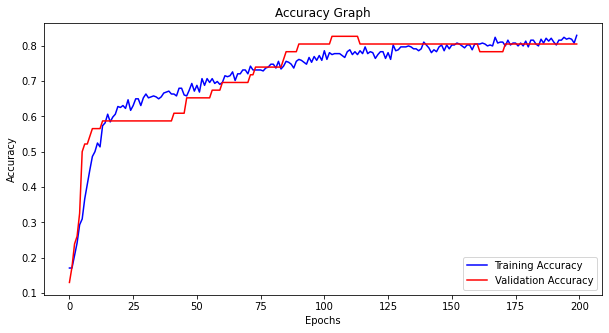

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['accuracy'],color='b',label='Training Accuracy')
plt.plot(hist.history['val_accuracy'],color='r',label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Graph")
plt.legend(loc='lower right')

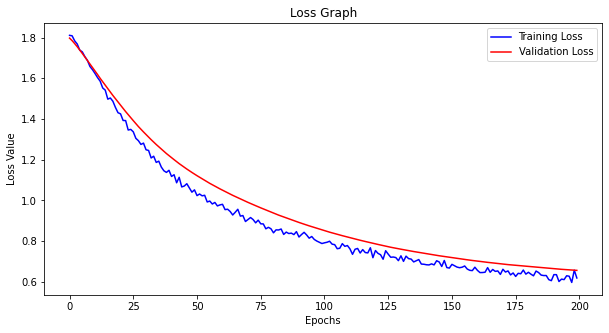

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(hist.history['loss'],color='b',label='Training Loss')
plt.plot(hist.history['val_loss'],color='r',label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.title("Loss Graph")
plt.legend(loc='upper right')

In [ ]:
predictions = model.predict([np.array(x_valid['meta'].tolist()),np.array(x_valid['image'].tolist())], verbose=0) 

In [ ]:
from sklearn.metrics import  precision_score, recall_score, accuracy_score,classification_report,roc_auc_score,roc_curve,auc
from tensorflow.keras.utils import to_categorical

#geting predictions on test dataset
y_pred = np.argmax(predictions, axis=1)
targetnames = ['ACK', 'BCC', 'MEL', 'NEV', 'SCC', 'SEK']

#getting the true labels per image 
y_true = y_valid

# Creating classification report 
report = classification_report(y_true, y_pred)

print("\nClassification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       0.94      1.00      0.97        16
           3       1.00      0.89      0.94         9
           4       1.00      0.67      0.80         3
           5       0.50      1.00      0.67         1

    accuracy                           0.96        46
   macro avg       0.89      0.91      0.88        46
weighted avg       0.97      0.96      0.96        46



Text(0.5, 1.0, 'Confusion Matrix')

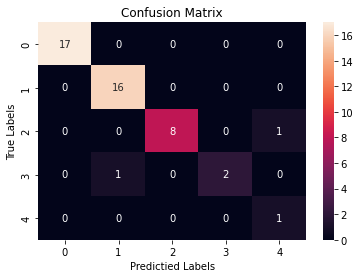

In [ ]:
import seaborn as sn
import pandas as pd
from sklearn.metrics import confusion_matrix
cmatrix = confusion_matrix(y_true, y_pred)
ax = plt.subplot()
sn.heatmap(cmatrix,annot=True,fmt='g',ax=ax)
ax.set_xlabel('Predictied Labels');ax.set_ylabel('True Labels');
ax.set_title('Confusion Matrix')

In [ ]:
y_valid

24     3
237    1
69     0
156    0
436    1
422    0
312    1
274    0
323    3
240    1
31     0
210    0
379    1
302    0
133    1
117    3
179    1
161    3
106    1
183    4
189    3
215    1
36     1
2      0
211    0
372    0
147    4
252    3
261    1
39     0
81     3
334    1
198    0
246    3
408    1
281    0
296    1
195    0
89     5
181    3
138    1
118    0
130    1
91     4
265    0
416    0
Name: label, dtype: int64

In [ ]:
y_test

100    0
412    0
387    0
269    3
395    4
383    0
419    0
325    1
139    1
437    1
38     1
8      0
251    0
257    0
391    1
165    3
356    1
331    3
231    0
43     4
95     1
450    5
157    2
368    1
187    0
114    5
194    3
400    5
225    3
128    5
12     0
154    1
405    1
72     1
56     1
242    5
19     1
373    1
98     3
310    5
168    0
53     1
143    1
57     3
407    1
278    4
Name: label, dtype: int64

In [ ]:
!jupyter nbconvert --to html PAD20+ML+Mobv2+2dense\(95_6\)\ \(1\).ipynb 

[NbConvertApp] Converting notebook PAD20+ML+Mobv2+2dense(95_6) (1).ipynb to html
[NbConvertApp] Writing 474270 bytes to PAD20+ML+Mobv2+2dense(95_6) (1).html
